In [ ]:
from collections import Counter, deque, namedtuple
from concurrent.futures import ProcessPoolExecutor, as_completed, TimeoutError
import glob
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib import colormaps
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from scipy import stats
from tqdm.notebook import tqdm

from google.colab import files

In [ ]:
config = {
    # Percolation
    'd': 100,
    'p': None, # default None: p = p_c
    'tau': 5/2, # fixed for Bethe lattice
    'D': 4, # fixed for Bethe lattice
    # Cluster distribution
    'expected_n_large': 1.0,
    'min_size': 300,
    'max_size': 30000000,
    # Simulation hyperparameters
    'seed': 0,
    'rng_batch_size': 250,
    'max_workers': os.cpu_count(),
    # Experiments & plots
    'do_cluster_plots': False,
    'min_n': 1,
    'max_n': 30000,
    'scaling_law_points': 50,
    'p_valid': 0.001,
    'individual_cluster_n_valid': 40,
    'do_scan': False,
    'scan_n_points': 2000,
    'scan_N': 500,
}

assert isinstance(config['d'], int)
assert config['d'] >= 6 # Bethe lattice is a valid approximation
config['z'] = 2*config['d']
config['n_neighbors'] = config['z'] - 1 # omit parent
config['p_c'] = 1/config['n_neighbors']

assert config['p'] is None or isinstance(config['p'], float)
if config['p'] is None:
    config['p'] = config['p_c']

assert isinstance(config['min_size'], int)
assert config['min_size'] >= 0
assert config['max_size'] == float('inf') or isinstance(config['max_size'], int)
assert config['max_size'] >= 1
assert config['max_size'] > config['min_size']

assert isinstance(config['seed'], int)
assert isinstance(config['rng_batch_size'], int)
assert config['rng_batch_size'] > 0

assert isinstance(config['min_n'], int)
assert config['min_n'] >= 1
assert isinstance(config['max_n'], int)
assert config['max_n'] > config['min_n']
assert isinstance(config['scaling_law_points'], int)
assert config['scaling_law_points'] > 1
assert isinstance(config['p_valid'], float)
assert 0 < config['p_valid'] < 1

rng = np.random.default_rng(seed=config['seed'])

In [ ]:
# Determine how many clusters to generate

# Since we throw out clusters larger than max_size, the resulting artificial
# break in the size distribution may distort the scaling curves. To prevent this,
# we'll generate few enough clusters so that the expected number of large clusters is small.

# Ideally, to limit distortion, we want no large clusters at all, or at most a few.
# Setting expected_n_large in the range 0.5 - 1 should accomplish this for most
# random seeds, while generating enough clusters to get a good distribution.

# Alternatively, to verify the CDF with low noise, set expected_n_large >> 1.

assert isinstance(config['expected_n_large'], (int, float))
assert config['expected_n_large'] > 0
assert config['expected_n_large'] <= 1 # optional, can comment out if inapplicable
config['n_clusters'] = int(config['expected_n_large']
                           * (config['max_size']/config['min_size'])**(config['tau'] - 2))
assert config['n_clusters'] >= 1
print(f"n_clusters: {config['n_clusters']}")

n_clusters: 316


In [ ]:
def save(filename, **kwargs):
    if not os.path.isdir("plots"):
        os.makedirs("plots")
    plt.savefig(f"plots/{filename}.png", bbox_inches='tight', **kwargs)
    plt.savefig(f"plots/{filename}.pdf", bbox_inches='tight', **kwargs)

In [ ]:
class ScalingLaw():
    """Return functions to compute model or data scaling."""

    def __init__(self, c, p, tau, verbose=True):
        self.c = c
        self.p = p
        self.tau = tau
        self.verbose = verbose
        # Define percolation constants
        self.alpha = (3 - self.tau)/(self.tau - 2)
        if self.p <= config['p_c']:
            self.cD = self.c/config['D']
        else:
            self.cD = self.c/config['d']
            if self.verbose:
                print("Using Euclidean cluster dimension!")
        self.b = 1 - (self.alpha + 1)/(self.cD + 1)
        self.aa = self.alpha/(1 + self.alpha)
        if self.verbose:
            print(f"tau: {self.tau:.3f}, alpha: {self.alpha:.3f}, "
                  f"c/D: {self.cD:.3f}, b: {self.b:.3f}, "
                  f"alpha/(1 + alpha): {self.aa:.3f}")
        # Create arrays for numerically estimating k_br
        # Multiply max_kbr by a conservative padding factor
        max_kbr = 100*config['n_clusters']
        self.sim_kbr = np.geomspace(1, max_kbr, num=int(50*np.log10(max_kbr)))
        self.sim_N = self.sim_kbr*(1 - self.sim_kbr**-self.b)/self.b
        assert np.all(np.diff(self.sim_N) > 0) # monotonically increasing

    def model_scaling(self, model):
        if model == 'ours':
            return self._model_scaling_ours
        elif model == 'manifold':
            return self._scaling_manifold
        elif model == 'quanta':
            return self._model_scaling_quanta
        else:
            raise ValueError(model)

    def data_scaling(self, model):
        if model == 'ours':
            return self._data_scaling_ours
        elif model == 'manifold':
            return self._scaling_manifold
        elif model == 'quanta':
            return self._data_scaling_quanta
        else:
            raise ValueError(model)

    def _model_scaling_ours(self, N):
        kbr = np.interp(N, self.sim_N, self.sim_kbr)
        loss = (N/kbr + 1/self.alpha)*kbr**-self.alpha
        norm_kbr = np.interp(1, self.sim_N, self.sim_kbr)
        norm = (1/norm_kbr + 1/self.alpha)*norm_kbr**-self.alpha
        loss /= norm
        return np.where(N > 1, loss, 1)

    def _data_scaling_ours(self, N):
        if self.cD == self.aa:
            loss = (self.alpha**-(self.cD + 1)
                    * (1 + self.cD*np.log(self.alpha) + self.cD*np.log(N))
                    * N**-self.cD)
            norm = self.alpha**-(self.cD + 1) * (1 + self.cD*np.log(self.alpha))
        else:
            coeff1 = self.alpha**-(self.aa + 1) / (1 - self.aa/self.cD)
            coeff2 = self.alpha**-(self.cD + 1) / (1 - self.cD/self.aa)
            loss = coeff1*N**-self.aa + coeff2*N**-self.cD
            norm = coeff1 + coeff2
        loss /= norm
        return np.where(N > 1, loss, 1)

    # kbr for model scaling predicted by our theory (Eq. 29)
    def kbr_ours(self, N):
        return np.interp(N, self.sim_N, self.sim_kbr)

    # n_k for model scaling predicted by our theory (Eq. 26)
    def n_k_ours(self, N, k):
        kbr = self.kbr_ours(N)
        a = self.b*N/(kbr**self.b - 1)
        n_k = a*k**(self.b - 1)
        n_k = np.where(k < kbr, n_k, 0)
        n_k = np.where(N >= 1, n_k, 0)
        return n_k

    # same function for model and data scaling
    def _scaling_manifold(self, N):
        return np.maximum(N, 1)**-self.cD

    def _model_scaling_quanta(self, N):
        return np.maximum(N, 1)**-self.alpha

    def _data_scaling_quanta(self, N):
        return np.maximum(N, 1)**-self.aa


# c = 2: piecewise constant function approximator
scaling_law = ScalingLaw(c=2, p=config['p'], tau=config['tau'])

tau: 2.500, alpha: 1.000, c/D: 0.500, b: -0.333, alpha/(1 + alpha): 0.500


In [ ]:
Cluster = namedtuple('Cluster', ['id', 'value', 'adj_matrix', 'root', 'distance', 'size'])

def generate_cluster(cluster_id, seed):
    """Simulate a cluster on the Bethe lattice.

    cluster_id: int
    config: dict
    seed: int

    Generate active sites via breadth-first iteration. Create target values
    following a random walk with a Gaussian innovation at each site. Then
    standardize the target values to standard normal for each cluster.
    """
    # Create a unique random number generator for this process
    process_rng = np.random.default_rng(seed)

    n_sites = 1
    row, col = [], []
    value = [0.0]
    queue = deque([0])
    roots = [-1]
    distances = [0]
    # Batch generate random variables for efficiency
    norm_i = binom_i = config['rng_batch_size'] + 1

    while queue and n_sites <= config['max_size']:
        root = queue.popleft()
        if binom_i >= config['rng_batch_size']:
            binomials = process_rng.binomial(config['n_neighbors'],
                                             config['p_c'],
                                             size=config['rng_batch_size'])
            binom_i = 0
        n_branch = binomials[binom_i]
        binom_i += 1
        if root == 0:
            n_branch += process_rng.binomial(1, config['p_c'])
        if n_branch:
            branch_sites = n_sites + np.arange(n_branch)
            n_sites += n_branch
            if norm_i + n_branch > config['rng_batch_size']:
                normals = process_rng.normal(size=config['rng_batch_size'])
                norm_i = 0
            branch_values = normals[norm_i:(norm_i + n_branch)] + value[root]
            norm_i += n_branch
            value.extend(branch_values)
            for site in branch_sites:
                row.extend([root, site])
                col.extend([site, root])
                queue.append(site)
                roots.append(root)
                distances.append(distances[root] + 1)

    if n_sites < config['min_size']:
        return "small", n_sites
    elif n_sites > config['max_size']:
        return "large", n_sites
    else:
        # Standardize the values
        value = np.array(value)
        value -= np.mean(value)
        value /= np.std(value)
        data = np.ones_like(row)
        adj_matrix = csr_matrix((data, (row, col)))
        roots, distances = np.array(roots), np.array(distances)
        n = len(value)
        return Cluster(id=n_clusters, value=value, adj_matrix=adj_matrix,
                       root=roots, distance=distances, size=len(value))

In [ ]:
# Generate percolation clusters on the Bethe lattice, parallel implementation

clusters = []
n_clusters = 0
small_counts = Counter()
n_large = 0
cluster_id = 0

with (
    tqdm(total=config['n_clusters']) as pbar,
    ProcessPoolExecutor(max_workers=config['max_workers']) as executor,
):
    futures = {}
    while n_clusters < config['n_clusters']:
        while (len(futures) < config['max_workers']
                and n_clusters + len(futures) < config['n_clusters']):
            # Generate a seed for each process from the top-level RNG
            seed = rng.integers(0, 2**32 - 1)
            future = executor.submit(generate_cluster, cluster_id, seed)
            futures[future] = cluster_id
            cluster_id += 1
        try:
            for future in as_completed(futures, timeout=0.0001):
                result = future.result()
                del futures[future]  # clean up the completed future
                if isinstance(result, Cluster):
                    clusters.append(result)
                    n_clusters += 1
                    pbar.update(1)
                elif result[0] == 'small':
                    small_counts[result[1]] += 1
                elif result[0] == 'large':
                    n_large += 1
        except TimeoutError:
            pass

n_small = sum(small_counts.values())
n_total = n_small + n_clusters + n_large
clusters.sort(key=lambda c: c.size, reverse=True)
print(f"n_small: {n_small}, n_clusters: {n_clusters}, n_large: {n_large}, n_total: {n_total}")

  0%|          | 0/316 [00:00<?, ?it/s]

n_small: 6348, n_clusters: 316, n_large: 0, n_total: 6664


In [ ]:
# Plot a few clusters for illustration

def plot_cluster(value, adj_matrix, i):
    show_label_cutoff = 80 # only show site index labels if fewer than this many sites
    size_factor = 5000 # controls size of plotted sites
    n_sites = len(value)
    G = nx.from_scipy_sparse_array(adj_matrix)
    cmap = colormaps["coolwarm"]
    colors = cmap((value - value.min()) / (value.max() - value.min()))
    pos = nx.kamada_kawai_layout(G)
    with_labels = n_sites < show_label_cutoff
    nx.draw(G, pos, with_labels=with_labels, node_size=size_factor/n_sites, node_color=colors, cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value.min(), vmax=value.max()))
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca())
    save(f"cluster_drawing_{i}")
    plt.show()

if config['do_cluster_plots']:
    n_plots_to_show = 4
    n_plots_so_far = 0
    for cluster in clusters:
        if n_plots_so_far >= n_plots_to_show:
            break
        if cluster.size > 2000: # drawing the plot is too slow
            continue
        plot_cluster(cluster.value, cluster.adj_matrix, n_plots_so_far)
        print(f"cluster size: {cluster.size}")
        n_plots_so_far += 1

There are 11416230 sites


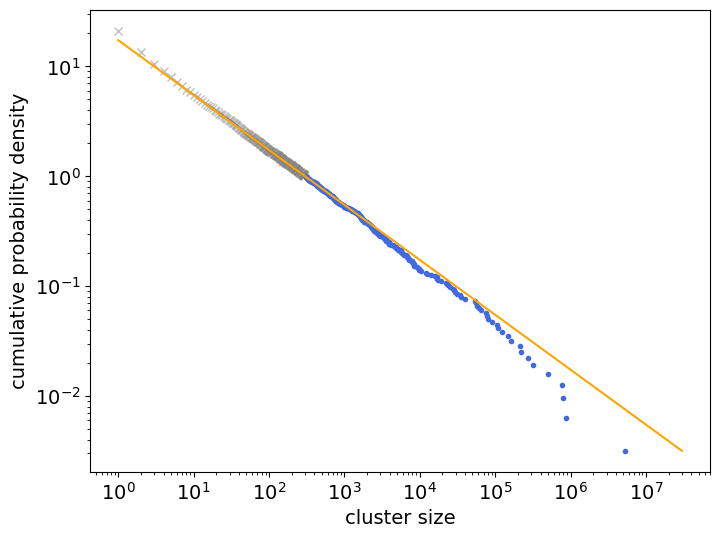

In [ ]:
# Plot cluster size distribution using the cumulative distribution function (CDF)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Compute the theoretical CDF for percolation clusters
# Product of 3 factors:
#    s^-tau: cluster number distribution
#    s: proportional probability to randomly select an s-cluster
#    s: integration of probability density to obtain CDF
sizes = np.arange(1, config['max_size'] + 1)
theoretical_cdf = (sizes/config['min_size'])**(2 - config['tau'])
ax.plot(sizes, theoretical_cdf, color='orange', zorder=1000)

# Count the clusters at each size s
sizes = [c.size for c in clusters]
config['n_sites'] = np.sum(sizes)
print(f"There are {config['n_sites']} sites")
size_counts = Counter(sizes)

# Compute the empirical CDF, which is less noisy than a histogram for a power-law distribution
kwargs = [{'marker': '.', 'color': 'royalblue'}, {'marker': 'x', 'color': 'gray', 'alpha': 0.5}]
n_extra = [n_large, n_clusters + n_large]
cdf_normalization = n_clusters + n_large
for i, counter in enumerate([size_counts, small_counts]):
    cluster_size, cluster_size_count = zip(*sorted(counter.items()))
    cluster_size, cluster_size_count = np.array(cluster_size), np.array(cluster_size_count, dtype=float)
    empirical_cdf = np.cumsum(cluster_size_count[::-1])[::-1] + n_extra[i]
    empirical_cdf /= cdf_normalization
    ax.plot(cluster_size, empirical_cdf, linestyle='none', **kwargs[i])

ax.set_xlabel("cluster size")
ax.set_ylabel("cumulative probability density")
ax.set_xscale('log')
ax.set_yscale('log')
save(f"cluster_size_distribution")

In [ ]:
def estimate_values(cluster, sorted_train_indices, sorted_test_indices):
    """Return the nearest-neighbor value for each node.

    By exploiting the Bethe lattice's structure, we achieve O(n^(3/2) log(n))
    average-case time complexity and O(n) space complexity, for n the cluster
    size. There are on average O(n^(1/2)) loop iterations, each performing O(n)
    binary searches with O(log(n)) complexity apiece. We compute node distances
    from scratch for the given indices because for large clusters, the O(n^2)
    space complexity of caching all the distances would eat up all the RAM.
    """
    roots = np.arange(cluster.size)
    # Ancestors of each node, eventually leading to the ultimate root (node 0)
    train_roots = roots[sorted_train_indices]
    test_roots = roots[sorted_test_indices]
    # Distances from each node to the ultimate root
    train_distances = cluster.distance[sorted_train_indices]
    test_distances = cluster.distance[sorted_test_indices]
    # Clusters were generated such that indices are ordered by distance to root
    assert np.all(train_distances[:-1] <= train_distances[1:])
    assert np.all(test_distances[:-1] <= test_distances[1:])
    train_values = cluster.value[sorted_train_indices]
    # Iteratively find train and test nodes with a common ancestor, going
    # from the outside in. The train-test distance is computed from the
    # train-root, test-root, and ancestor-root distances. If there's multiple
    # nearest neighbors, the first one found is used.
    nearest_distance = np.full_like(sorted_test_indices, cluster.size)
    nearest_value = np.zeros_like(sorted_test_indices, dtype=float)
    max_distance = max(np.max(train_distances), np.max(test_distances))
    for curr_distance in range(max_distance, 0, -1):
        # Decrement roots one level lower/inward towards the ultimate root
        train_mask = train_distances >= curr_distance
        test_mask = test_distances >= curr_distance
        train_roots[train_mask] = cluster.root[train_roots[train_mask]]
        test_roots[test_mask] = cluster.root[test_roots[test_mask]]
        # Find train nodes with the same root: they have a common ancestor
        # Sorting the roots and doing the binary search are both O(n log(n)),
        # but the search step seems to be more computionally expensive.
        # Stable sort breaks ties in favor of the smallest train-root distance
        sorter = train_roots.argsort(kind='stable')
        inds = np.searchsorted(train_roots, test_roots, sorter=sorter)
        inds = np.minimum(inds, len(train_roots) - 1)
        inds = sorter[inds]
        # Ignore indices that aren't actually matches
        mask = (train_roots[inds] == test_roots)
        # Compute distance between nodes using their common ancestor
        # As a minor optimization, we'll add the test_distances term
        # after the loop, since it's constant
        neighbor_distance = train_distances[inds] - 2*cluster.distance[test_roots]
        # Update distance and value if the node is the closest found so far
        is_nearest = neighbor_distance < nearest_distance
        mask &= is_nearest
        nearest_distance[mask] = neighbor_distance[mask]
        nearest_value[mask] = train_values[inds[mask]]
    nearest_distance += test_distances

    # # Uncomment to validate the nearest-neighbor distance calculation
    # # This is slow and memory-hungry beyond size ~ 1000 or so,
    # # hence the need for the algorithm above.
    # from scipy.sparse.csgraph import shortest_path
    # dist_matrix = shortest_path(cluster.adj_matrix)
    # selected_distance = dist_matrix[np.ix_(test_indices, train_indices)]
    # true_distance = np.min(selected_distance, axis=1).astype(int)
    # assert np.all(nearest_distance == true_distance)

    # See derivation of Bayesian nearest neighbor estimator in Appendix H
    estimated_var = nearest_distance/np.sqrt(cluster.size)
    predicted_value = nearest_value / (1 + estimated_var)
    return predicted_value

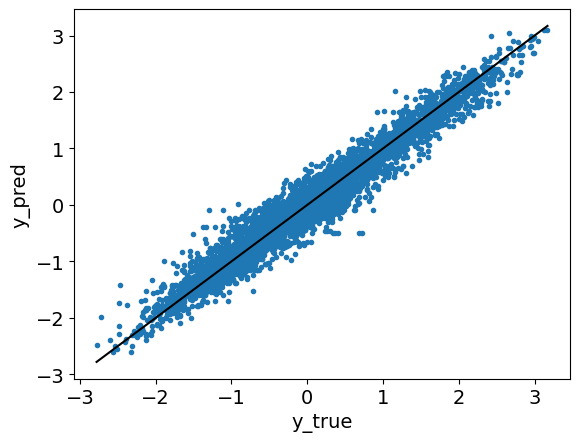

0.05200083683666322


In [ ]:
def predict(cluster_idx, p_train, p_test, random_seed):
    """Return the predicted and true values for a single cluster.

    cluster_idx: int, index of cluster in clusters list
    p_train: float, fraction of sites for training
    p_test: float, fraction of sites for testing
    random_seed: int, seed for random number generator

    Returns:
    y_pred: array of predicted values
    y_true: array of true values
    """
    assert isinstance(cluster_idx, int), cluster_idx
    assert 0 <= cluster_idx < len(clusters), cluster_idx
    assert isinstance(p_train, float), p_train
    assert 0 <= p_train <= 1, p_train
    assert isinstance(p_test, float), p_test
    assert 0 <= p_test <= 1, p_test
    assert 0 <= p_train + p_test <= 1, (p_train, p_test)
    cluster = clusters[cluster_idx]
    size = cluster.size
    process_rng = np.random.default_rng(seed=random_seed)
    # Select an exact number of test sites, to reduce noise
    n_test = np.round(p_test*size).astype(int)
    # Emulate realistic random fluctuations in training sites
    n_train = process_rng.binomial(size - n_test, p_train/(1 - p_test))
    inds = process_rng.choice(size, size=(n_train + n_test), replace=False)
    inds_train, inds_test = inds[:n_train], inds[n_train:]
    inds_train.sort()
    inds_test.sort()
    if inds_train.size == 0 or inds_test.size == 0:
        y_pred = np.zeros(len(inds_test))
    else:
        y_pred = estimate_values(cluster, inds_train, inds_test)
    y_true = cluster.value[inds_test]
    return y_pred, y_true


def compute_loss(clusters, p_train, p_valid=config['p_valid'],
                 max_workers=config['max_workers']):
    """Return the loss and number of sites for each value of p_train.

    clusters: list of Cluster objects
    p_train: array of floats, fractions of sites for training
    p_valid: float or array of floats, fractions of sites for validation
    """
    assert isinstance(p_train, np.ndarray)
    assert p_train.shape[-1] == len(clusters)
    assert np.all(0 <= p_train)
    assert np.all(p_train < 1)
    p_valid = np.broadcast_to(np.array(p_valid), p_train.shape)
    assert np.all(0 <= p_valid)
    assert np.all(p_valid < 1)
    loss = np.zeros_like(p_train)
    num_sites = np.full_like(p_train, -1, dtype=int)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        random_seed = rng.integers(0, 2**32 - 1, size=p_train.shape)
        futures = {executor.submit(predict, idx[-1], p_train[idx], p_valid[idx],
                                   random_seed[idx]): idx
                   for idx in np.ndindex(p_train.shape)}
        for future in tqdm(as_completed(futures), total=p_train.size):
            idx = futures[future]
            y_pred, y_true = future.result()
            del futures[future] # clean up the completed future
            squared_error = (y_pred - y_true)**2
            loss[idx] = np.mean(squared_error) if len(y_true) > 0 else 0.0
            num_sites[idx] = len(y_true)
    assert np.isfinite(loss).all()
    assert (loss >= 0).all()
    assert (num_sites >= 0).all()
    return loss, num_sites


def validate_p_train(p_train, threshold=0.95):
    p_train = np.array(p_train)
    assert np.all(0 <= p_train)
    # adjusting p_train with a scale factor could increase it above 1
    if np.any(p_train > threshold):
        print(f"Warning: p_train values above {threshold}: {p_train[p_train > threshold]}")
    p_train = np.minimum(p_train, threshold)
    return p_train


def plot_predictions(y_pred, y_true):
    plt.scatter(y_true, y_pred, marker='.')
    xs = np.linspace(min(np.min(y_true), np.min(y_pred)),
                     max(np.max(y_true), np.max(y_pred)),
                     100)
    plt.plot(xs, xs, '-', zorder=100, color='k')
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.show()

# Spot check some predictions: should be unbiased relative to true values
p_train = 0.001
p_train = validate_p_train(p_train)
y_pred, y_true = predict(0, p_train, config['p_valid'], 0)
plot_predictions(y_pred, y_true)
print(np.mean((y_pred - y_true)**2))

In [ ]:
def fit_scaling_law(size, loss, model_fn, verbose=True):
    def fn(size, scale_factor):
        return np.log(model_fn(size/scale_factor))
    popt, pcov = curve_fit(fn, size, np.log(loss),
                           p0=[5], bounds=(1, np.inf),
                           loss='huber')
    perr = np.sqrt(np.diag(pcov))
    scale_factor, scale_factor_err = popt[0], perr[0]
    if verbose:
        print(f"Best fit scale factor: {scale_factor:.2g} +- {scale_factor_err:.2g}")
    model_loss = model_fn(size/scale_factor)
    return model_loss, scale_factor, scale_factor_err


def plot_scaling_law(size, loss, model_loss,
                     name=None,
                     total_sites=config['n_sites']):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(size, loss, color='royalblue', marker='o', zorder=0)
    ax.plot(size, model_loss, linestyle='-', color='black')
    ax.axhline(1.0, color='k', linestyle=':', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("training examples")
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ax2.set_xlim(np.array(ax.get_xlim())/total_sites)
    ax2.set_xlabel('training dataset fraction')
    ax.set_ylabel("error")
    if name is not None:
        save(f"scaling_law_{name}")
    plt.show()

In [ ]:
# Compute the scaling curve for each cluster individually.
# These should match the theoretical prediction of manifold approximation scaling.
sizes = np.array([c.size for c in clusters])

min_n_train_sites = 1
max_n_train_sites = 10000
min_p_train = min_n_train_sites/sizes
max_p_train = np.minimum(max_n_train_sites/sizes, 0.1)
p_train = np.geomspace(1/sizes, max_p_train, num=config['scaling_law_points'])
assert p_train.shape == (config['scaling_law_points'], config['n_clusters'])
p_train = validate_p_train(p_train)

p_valid = config['individual_cluster_n_valid']/sizes
assert p_valid.shape == (config['n_clusters'],)

cluster_losses, _n_sites = compute_loss(clusters, p_train, p_valid=p_valid)

  0%|          | 0/15800 [00:00<?, ?it/s]

Best fit scale factor: 11 +- 1.1


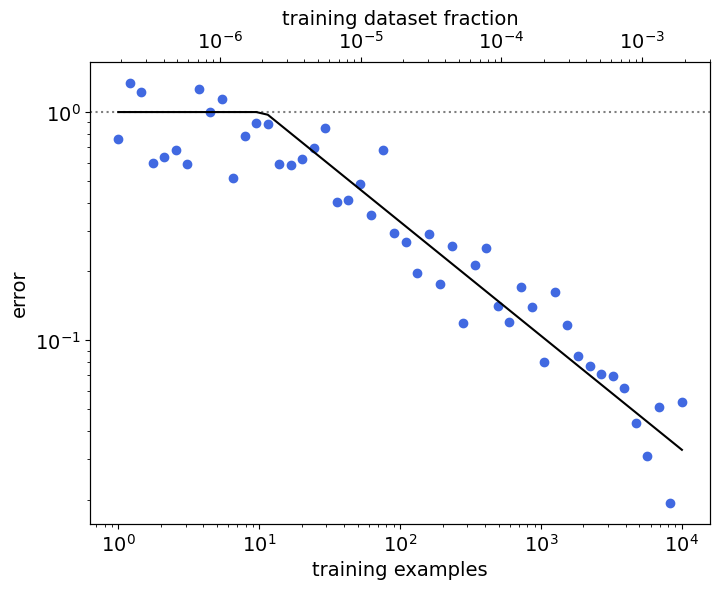

Best fit scale factor: 12 +- 1.1


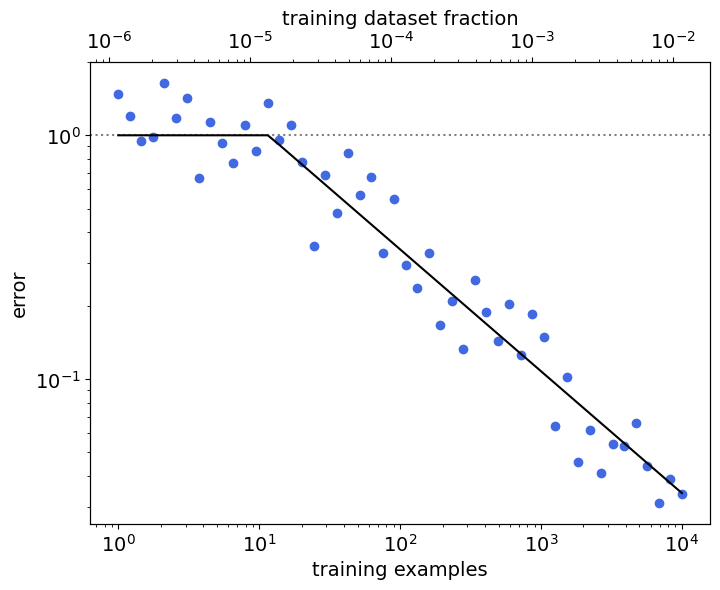

Best fit scale factor: 21 +- 2


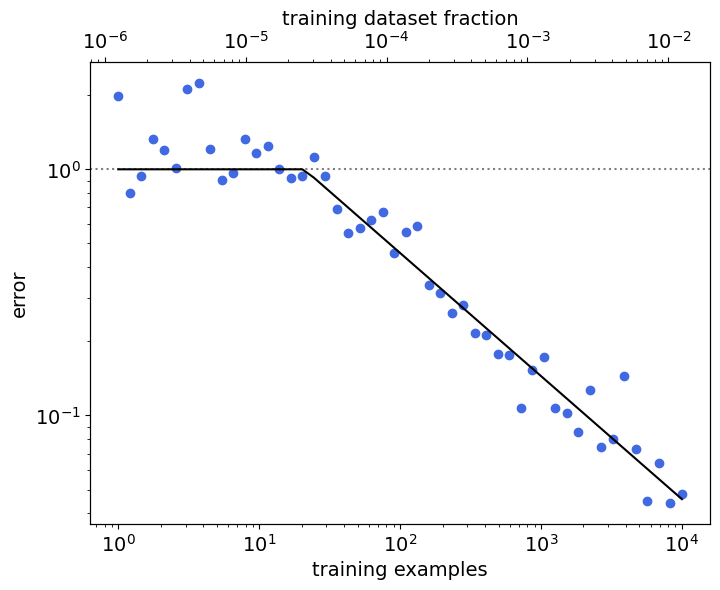

Best fit scale factor: 2.2 +- 0.26


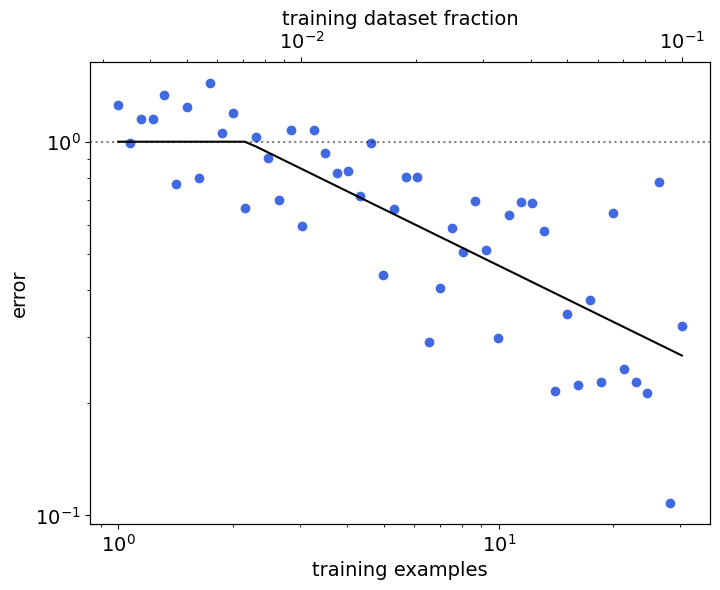

In [ ]:
# For each cluster, compute the scale factor between # data points and # DOF
# Since scaling starts when # DOF = 1, this factor also determines the break
# where the "small data" region ends and scaling begins.

model_fn = scaling_law.data_scaling("manifold")
expected_train_sizes = p_train*sizes
assert (expected_train_sizes > 0).all()
assert (expected_train_sizes <= sizes).all()
scale_factors = np.zeros(config['n_clusters'])
scale_factor_errs = np.zeros(config['n_clusters'])
indices_to_plot = set([0,
                       min(1, config['n_clusters'] - 1),
                       min(2, config['n_clusters'] - 1),
                       config['n_clusters'] - 1])
for i in range(config['n_clusters']):
    plot_curve = i in indices_to_plot
    model_loss, scale_factor, scale_factor_err = fit_scaling_law(expected_train_sizes[:, i],
                                                                 cluster_losses[:, i],
                                                                 model_fn,
                                                                 verbose=plot_curve)
    scale_factors[i] = scale_factor
    scale_factor_errs[i] = scale_factor_err
    # Print some example scaling curves
    if plot_curve:
        plot_scaling_law(expected_train_sizes[:, i], cluster_losses[:, i], model_loss,
                         name=f"cluster_{i}", total_sites=sizes[i])

mean scale factor: 5.517032459004143
weighted mean scale factor: 9.289525441941098
[ 1.          4.06519766 18.08785241]


Text(0, 0.5, 'scale factor')

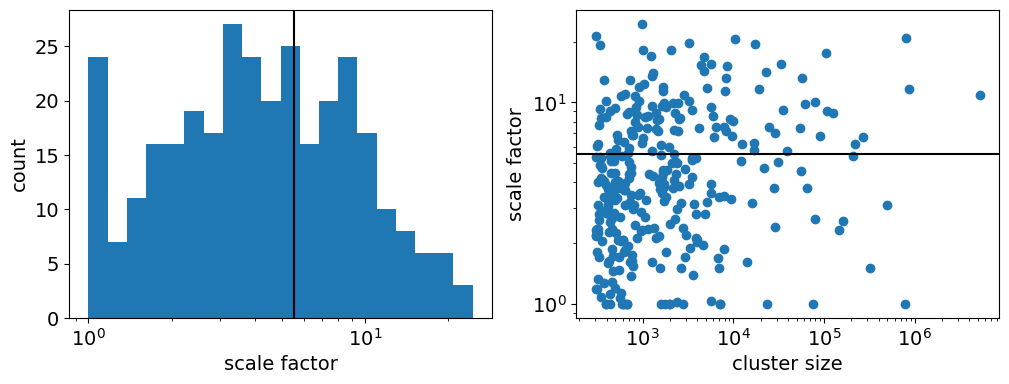

In [ ]:
# Plot distributions of scale factors

sizes = np.array([c.size for c in clusters])
mean_scale_factor = np.mean(scale_factors)
weighted_mean_scale_factor = np.average(scale_factors, weights=sizes)
print(f"mean scale factor: {mean_scale_factor}")
print(f"weighted mean scale factor: {weighted_mean_scale_factor}")
print(np.percentile(scale_factors, [2.5, 50, 97.5]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

n_bins = 20
__, bins = np.histogram(np.log10(scale_factors), bins=n_bins)
bins = 10**bins
axes[0].hist(scale_factors, bins=bins)
axes[0].axvline(mean_scale_factor, color='k')
axes[0].set_xscale('log')
axes[0].set_xlabel("scale factor")
axes[0].set_ylabel("count")

axes[1].plot(sizes, scale_factors, marker='o', linestyle='none')
axes[1].axhline(mean_scale_factor, color='k')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel("cluster size")
axes[1].set_ylabel("scale factor")

In [ ]:
# Compute parameterized model scaling, scanning over random parameter combinations

b_lo = -5.05
b_hi = 5.05
bs = rng.uniform(b_lo, b_hi, size=config['scan_n_points'])

kbr_lo = 1
kbr_hi = min(1000, config['n_clusters'])
kbrs = np.exp(rng.uniform(np.log(kbr_lo),
                          np.log(kbr_hi),
                          size=config['scan_n_points']))


def n_k_parameterized(N, k, b, kbr):
    """Compute probability that a cluster site is selected.

    N: array broadcastable with k, total DOF
    k: array broadcastable with N, cluster rank
    b: float
    kbr: float

    Returns:
    n_k: array of floats with shape broadcasted from N and k
        Probability that a cluster site is selected.
    """
    n_k = k**(b - 1.0)
    n_k = np.where(k <= kbr, n_k, 0)
    norm = np.sum(n_k, axis=1, keepdims=True)/N
    n_k = n_k/norm
    return n_k


k_arr = np.arange(1, len(clusters) + 1)[None, :]
s_arr = np.array([c.size for c in clusters])[None, :]
n_k_arr = np.zeros((config['scan_n_points'], config['n_clusters']))
for i, (b, kbr) in enumerate(zip(bs, kbrs)):
    n_k_arr[i] = n_k_parameterized(config['scan_N'], k_arr, b, kbr)

if config['do_scan']:
    p_train = n_k_arr*scale_factors/s_arr
    p_train = validate_p_train(p_train)
    loss, n_sites = compute_loss(clusters, p_train)
    scan_loss = np.sum(loss*n_sites, axis=1)/np.sum(n_sites, axis=1)

In [ ]:
# Plot parameterized model scaling

if config['do_scan']:
    n_fine = 200
    fine_bs = np.linspace(np.min(bs), np.max(bs), n_fine)
    fine_kbrs = np.geomspace(np.min(kbrs), np.max(kbrs), n_fine)
    x_fine, y_fine = np.meshgrid(fine_bs, fine_kbrs, indexing='ij')
    z_fine = griddata((bs, np.log(kbrs)), scan_loss, (x_fine, np.log(y_fine)),
                    method='nearest', rescale=True)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    pos = ax.pcolormesh(x_fine, y_fine, z_fine, shading='auto', cmap='magma_r')
    fig.colorbar(pos, ax=ax, label='loss')
    ax.set_xlabel('$b$')
    ax.set_ylabel('$k_{br}$')
    ax.set_yscale('log')
    ax.text(0.05, 0.91, f"N = {config['scan_N']}", transform=ax.transAxes)

    predicted_b = scaling_law.b
    predicted_kbr = scaling_law.kbr_ours(config['scan_N'])

    plt.plot(predicted_b, predicted_kbr, marker='x', markersize=12, color='k')

    save(f"parameterized_model_scaling_loss_N{config['scan_N']}")

In [ ]:
n_examples = np.geomspace(config['min_n'], config['max_n'], num=config['scaling_law_points'])[:, None]
assert (n_examples > 0).all()

  0%|          | 0/15800 [00:00<?, ?it/s]

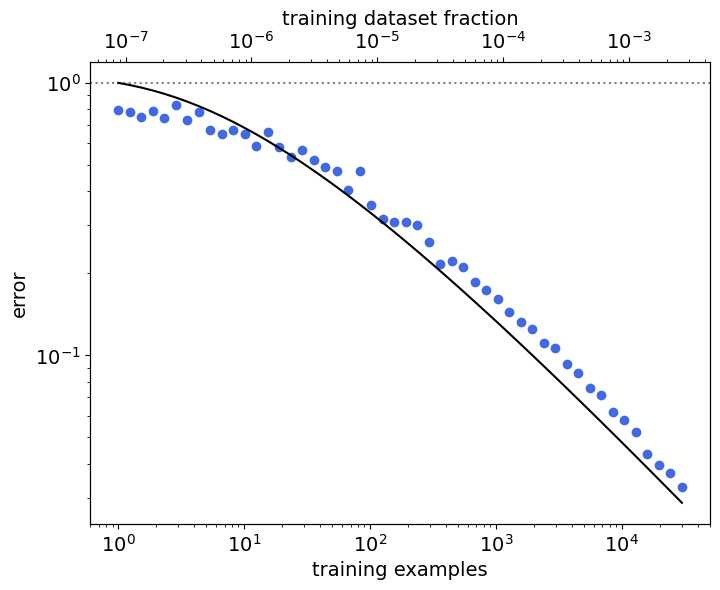

In [ ]:
# Compute model scaling
n_k = scaling_law.n_k_ours(n_examples, k_arr)
p_train = n_k*scale_factors/s_arr
p_train = validate_p_train(p_train)
cluster_loss, n_sites = compute_loss(clusters, p_train)
model_scaling_loss = np.sum(cluster_loss*n_sites, axis=1)/np.sum(n_sites, axis=1)

# Plot model scaling
scaling_fn = scaling_law.model_scaling("ours")
predicted_loss = scaling_fn(n_examples)
plot_scaling_law(n_examples, model_scaling_loss, predicted_loss, "model_scaling")

  0%|          | 0/15800 [00:00<?, ?it/s]

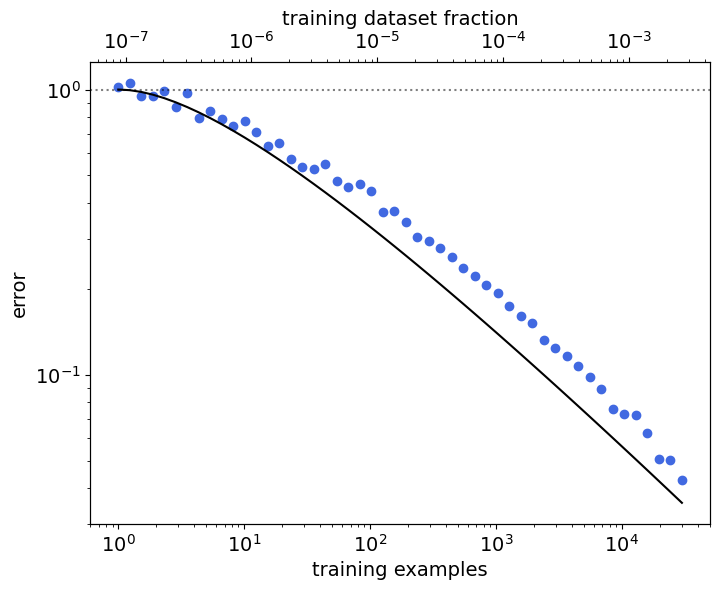

In [ ]:
# Compute data scaling
p_train = n_examples*scale_factors/config['n_sites']
p_train = validate_p_train(p_train)
cluster_loss, n_sites = compute_loss(clusters, p_train)
data_scaling_loss = np.sum(cluster_loss*n_sites, axis=1)/np.sum(n_sites, axis=1)

# Plot data scaling
scaling_fn = scaling_law.data_scaling("ours")
predicted_loss = scaling_fn(n_examples)
plot_scaling_law(n_examples, data_scaling_loss, predicted_loss, "data_scaling")

In [ ]:
# Download results
if not os.path.isdir("results"):
    os.makedirs("results")
fname = f"results/results_seed{config['seed']}.npz"
np.savez(fname,
         model_scaling_loss=model_scaling_loss,
         data_scaling_loss=data_scaling_loss,
         config=config)
files.download(f"/content/{fname}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Combine model and data scaling results from all runs

def validate_config(dict1, dict2, ignore_keys=None):
    if ignore_keys is None:
        ignore_keys = []
    dict1_filtered = {k: v for k, v in dict1.items() if k not in ignore_keys}
    dict2_filtered = {k: v for k, v in dict2.items() if k not in ignore_keys}
    if dict1_filtered != dict2_filtered:
        diff1 = {k: v for k, v in dict1_filtered.items()
                 if k not in dict2_filtered or dict2_filtered[k] != v}
        diff2 = {k: v for k, v in dict2_filtered.items()
                 if k not in dict1_filtered or dict1_filtered[k] != v}
        raise ValueError(f"Dictionaries are not identical. Differences:\nIn dict1: {diff1}\nIn dict2: {diff2}")


file_pattern = 'results_seed*.npz'
ignore_keys = ['seed', 'n_sites', 'do_scan', 'do_cluster_plots',
               'scan_n_points', 'scan_N']
model_scaling_losses = []
data_scaling_losses = []

# Validate all configs to confirm they're compatible
run_config = None
for file_path in glob.glob(f"results/{file_pattern}"):
    data = np.load(file_path, allow_pickle=True)
    seed_config = data['config'].item()
    if run_config is None:
        run_config = seed_config
    else:
        validate_config(run_config, seed_config, ignore_keys)
    model_scaling_losses.append(data['model_scaling_loss'])
    data_scaling_losses.append(data['data_scaling_loss'])
model_scaling_loss = np.stack(model_scaling_losses)
data_scaling_loss = np.stack(data_scaling_losses)
print(f"Model scaling loss shape: {model_scaling_loss.shape}")
print(f"Data scaling loss shape: {data_scaling_loss.shape}")

Model scaling loss shape: (50, 50)
Data scaling loss shape: (50, 50)


tau: 2.500, alpha: 1.000, c/D: 0.500, b: -0.333, alpha/(1 + alpha): 0.500


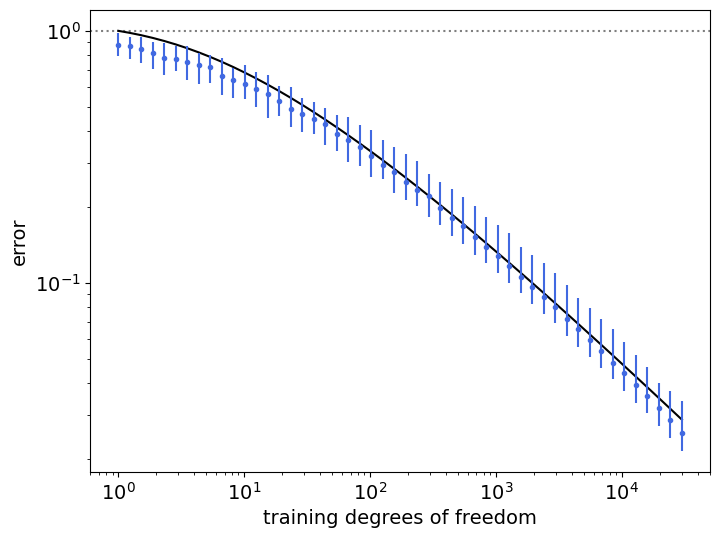

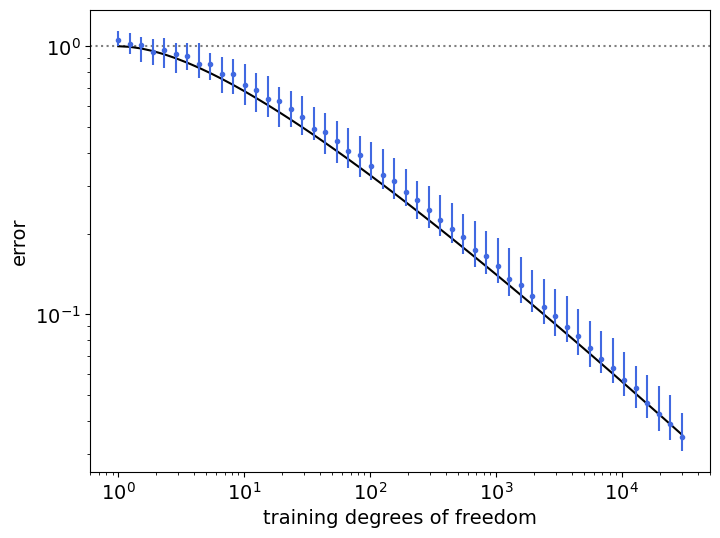

In [ ]:
# Plot overall model and data scaling

scaling_law = ScalingLaw(c=2, p=run_config['p'], tau=run_config['tau'])
n_examples = np.geomspace(run_config['min_n'], run_config['max_n'],
                          num=run_config['scaling_law_points'])[:, None]
assert (n_examples > 0).all()

def plot_overall_scaling_law(n_examples, loss, scaling_fn, name):
    predicted_loss = scaling_fn(n_examples)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(n_examples, predicted_loss, linestyle='-', color='black')
    ax.axhline(1.0, color='k', linestyle=':', alpha=0.5)
    points = np.percentile(loss, [50, 16, 84], axis=0)
    ax.errorbar(n_examples, points[0], yerr=np.abs(points[1:] - points[0]),
                color='royalblue', marker='.', linestyle='none')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("training degrees of freedom")
    ax.set_ylabel("error")
    save(name)

plot_overall_scaling_law(n_examples, model_scaling_loss,
                         scaling_law.model_scaling("ours"),
                         "model_scaling")

plot_overall_scaling_law(n_examples, data_scaling_loss,
                         scaling_law.data_scaling("ours"),
                         "data_scaling")

In [ ]:
# Download plots
!cd /content/plots && zip -r ../simulation_plots.zip *
files.download("simulation_plots.zip")

  adding: cluster_size_distribution.pdf (deflated 20%)
  adding: cluster_size_distribution.png (deflated 7%)
  adding: data_scaling.pdf (deflated 27%)
  adding: data_scaling.png (deflated 13%)
  adding: model_scaling.pdf (deflated 27%)
  adding: model_scaling.png (deflated 13%)
  adding: scaling_law_cluster_0.pdf (deflated 28%)
  adding: scaling_law_cluster_0.png (deflated 15%)
  adding: scaling_law_cluster_1.pdf (deflated 28%)
  adding: scaling_law_cluster_1.png (deflated 13%)
  adding: scaling_law_cluster_2.pdf (deflated 28%)
  adding: scaling_law_cluster_2.png (deflated 14%)
  adding: scaling_law_cluster_315.pdf (deflated 30%)
  adding: scaling_law_cluster_315.png (deflated 15%)
  adding: scaling_law_data_scaling.pdf (deflated 28%)
  adding: scaling_law_data_scaling.png (deflated 13%)
  adding: scaling_law_model_scaling.pdf (deflated 28%)
  adding: scaling_law_model_scaling.png (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>